EDA of the data

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [51]:
data = pd.read_csv("housing.csv")
print(data.head())
print(data.info())
print(data.describe())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

In [52]:
print(data.isnull().sum())


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [53]:
# Drop missing values
data = data.dropna()


feature selection by seeing the correlation matrix

Selected features: ['median_income', 'ocean_proximity_INLAND', 'ocean_proximity_NEAR BAY']


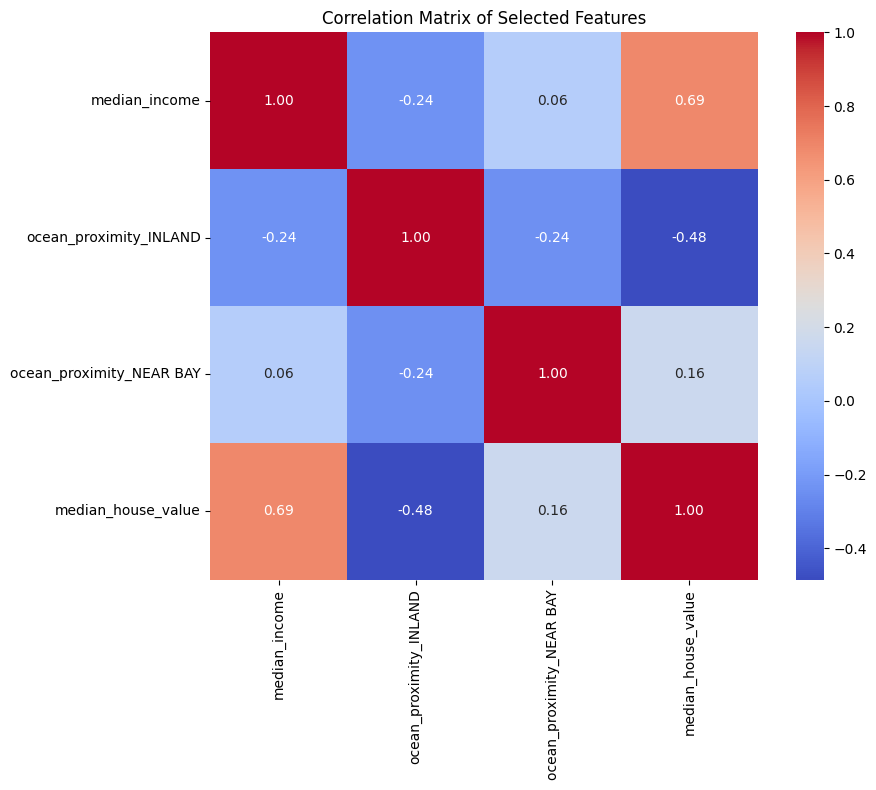

In [54]:
# One-hot encode categorical column
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

# Calculate correlation matrix
correlation_matrix = data.corr()
correlations = correlation_matrix['median_house_value'].abs()
selected_features = correlations[correlations > 0.15].index.tolist()
selected_features.remove('median_house_value')
print("Selected features:", data[selected_features].columns.tolist())

# Plot correlation heatmap for selected features + target
plt.figure(figsize=(10, 8))
sns.heatmap(
    data[selected_features + ['median_house_value']].corr(), 
    annot=True, fmt=".2f", cmap='coolwarm', square=True
)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()


In [55]:

# Prepare features and target
X = data[selected_features]
y = data['median_house_value']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_with_bias = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]  # Add bias term


# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled_with_bias, y, test_size=0.2, random_state=42)


Linear regression using python only

In [56]:
import time

# Predict function
def predict(X, weights):
    preds = []
    for row in X:
        pred = 0
        for i in range(len(weights)):
            pred += row[i] * weights[i]
        preds.append(pred)
    return preds


def compute_cost(X, y, weights):
    m = len(y)
    total_error = 0
    preds = predict(X, weights)
    for i in range(m):
        error = preds[i] - y[i]
        total_error += error ** 2
    cost = total_error / (2 * m)
    return cost


def gradient_descent(X, y, weights, learning_rate, epochs):
    m = len(y)
    cost_history = []

    for epoch in range(epochs):
        preds = predict(X, weights)

        
        gradients = []
        for j in range(len(weights)):
            grad_sum = 0
            for i in range(m):
                error = preds[i] - y[i]
                grad_sum += error * X[i][j]
            gradients.append(grad_sum / m)

        
        for j in range(len(weights)):
            weights[j] = weights[j] - learning_rate * gradients[j]

        # Calculate cost and save
        cost = compute_cost(X, y, weights)
        cost_history.append(cost)

    return weights, cost_history




In [57]:

X_train_list = X_train.tolist()
y_train_list = y_train.tolist()

# Initialize weights with zeros
weights_init = [0.0] * len(X_train[0])

# Run gradient descent and time it
start_time = time.time()
final_weights, cost_history = gradient_descent(
    X_train_list, y_train_list, weights_init, learning_rate=0.01, epochs=1000)
end_time = time.time()

print("Pure Python Gradient Descent Time:", round(end_time - start_time, 4), "seconds")

Pure Python Gradient Descent Time: 9.4758 seconds


Optimized numpy implementation

In [58]:
import numpy as np

# Prediction function using numpy
def predict_np(X_scaled_bias, weights):
    return np.dot(X_scaled_bias, weights)

# Compute cost function with numpy
def compute_cost_np(X_scaled_bias, y, weights):
    m = len(y)
    preds = predict_np(X_scaled_bias, weights)
    errors = preds - y
    cost = (1/(2*m)) * np.dot(errors.T, errors)
    return cost

# Gradient descent with numpy
def gradient_descent_np(X_scaled_bias, y, weights, learning_rate, epochs):
    m = len(y)
    cost_history = []

    for epoch in range(epochs):
        preds = predict_np(X_scaled_bias, weights)
        errors = preds - y
        gradients = (1/m) * np.dot(X_scaled_bias.T, errors)
        weights = weights - learning_rate * gradients
        cost = compute_cost_np(X_scaled_bias, y, weights)
        cost_history.append(cost)

    return weights, cost_history




In [59]:
# Initialize weights as zeros
weights_np = np.zeros(X_train.shape[1])

# Run and time numpy gradient descent
start_time_np = time.time()
final_weights_np, cost_history_np = gradient_descent_np(
    X_train, y_train.values, weights_np, learning_rate=0.01, epochs=500)
end_time_np = time.time()

print("NumPy Gradient Descent Time:", round(end_time_np - start_time_np, 4), "seconds")

NumPy Gradient Descent Time: 0.1203 seconds


Using sklearn

In [60]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

start_time_sk = time.time()
model.fit(X_train, y_train)
end_time_sk = time.time()

print("Scikit-learn Linear Regression Fit Time:", round(end_time_sk - start_time_sk, 4), "seconds")


Scikit-learn Linear Regression Fit Time: 0.0017 seconds


Evaluation


In [61]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to compute metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Predictions for validation set
preds_py = predict(X_val.tolist(), final_weights)
preds_np = predict_np(X_val, final_weights_np)
preds_sk = model.predict(X_val)

# Evaluate each model
mae_py, rmse_py, r2_py = evaluate(y_val, preds_py)
mae_np, rmse_np, r2_np = evaluate(y_val, preds_np)
mae_sk, rmse_sk, r2_sk = evaluate(y_val, preds_sk)

print("\nEvaluation Metrics on Validation Set:")

print("Pure Python Linear Regression:")
print("MAE:", mae_py)
print("RMSE:", rmse_py)
print("R2 Score:", r2_py)

print("\nNumPy Linear Regression:")
print("MAE:", mae_np)
print("RMSE:", rmse_np)
print("R2 Score:", r2_np)

print("\nScikit-learn Linear Regression:")
print("MAE:", mae_sk)
print("RMSE:", rmse_sk)
print("R2 Score:", r2_sk)



Evaluation Metrics on Validation Set:
Pure Python Linear Regression:
MAE: 54746.42144414328
RMSE: 75248.76652421166
R2 Score: 0.5859376960345541

NumPy Linear Regression:
MAE: 54516.62662819402
RMSE: 75292.89544568426
R2 Score: 0.5854519078549785

Scikit-learn Linear Regression:
MAE: 54747.71203219531
RMSE: 75248.50194391274
R2 Score: 0.5859406077775801


c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Visualization

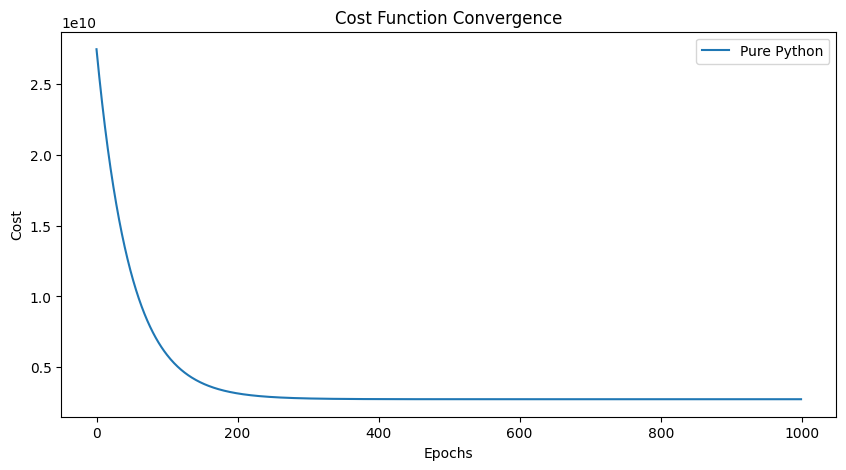

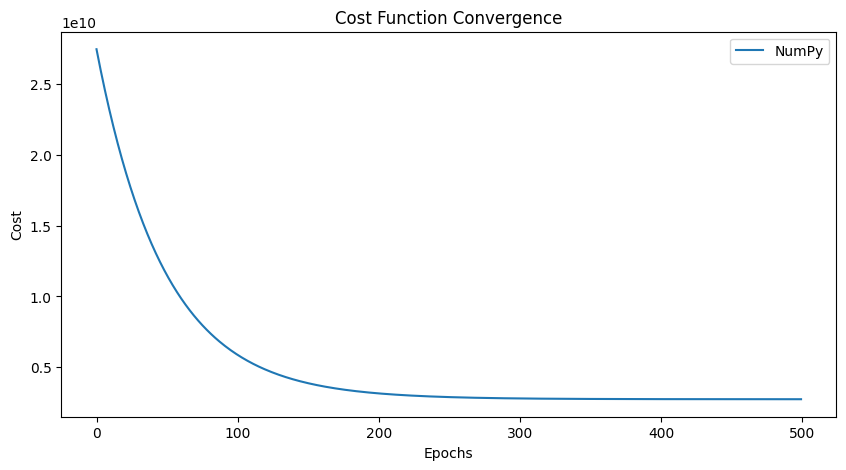

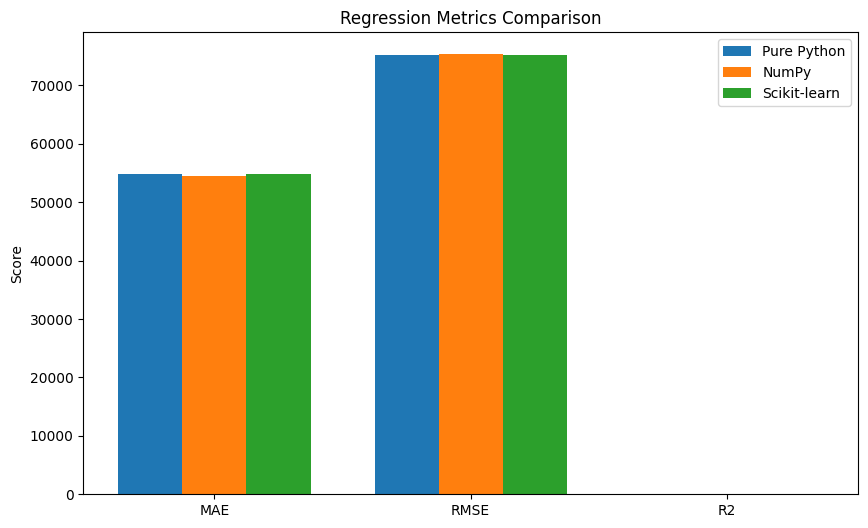

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Plot cost convergence for pure Python and NumPy
plt.figure(figsize=(10, 5))
plt.plot(cost_history, label="Pure Python")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost Function Convergence")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(cost_history_np, label="NumPy")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost Function Convergence")
plt.legend()
plt.show()

# Bar chart comparing metrics
labels = ['MAE', 'RMSE', 'R2']
py_metrics = [mae_py, rmse_py, r2_py]
np_metrics = [mae_np, rmse_np, r2_np]
sk_metrics = [mae_sk, rmse_sk, r2_sk]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, py_metrics, width, label='Pure Python')
ax.bar(x, np_metrics, width, label='NumPy')
ax.bar(x + width, sk_metrics, width, label='Scikit-learn')

ax.set_ylabel('Score')
ax.set_title('Regression Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
